Random Forest
=======

Libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(100000)

In [3]:
data.head()

,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,disbursement_method,dti,...,revol_util,sub_grade,tax_liens,term,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,verification_status
188513,GA,65000.0,Individual,17271.0,164.0,95.7,2.0,0.0,Cash,24.78,...,42.7,C4,0.0,36 months,0.0,200126.0,29532.0,3800.0,43501.0,Source Verified
661886,OH,34000.0,Individual,18871.0,5313.0,21.9,0.0,0.0,Cash,20.16,...,46.5,B2,0.0,36 months,0.0,161265.0,22999.0,6800.0,15365.0,Source Verified
740562,VA,118000.0,Individual,30724.0,2662.0,78.0,0.0,0.0,Cash,20.43,...,77.3,B2,0.0,36 months,0.0,532565.0,288493.0,12100.0,266891.0,Source Verified
584065,FL,34000.0,Individual,13382.0,2504.0,85.3,0.0,0.0,Cash,12.71,...,62.2,B2,0.0,36 months,0.0,100740.0,14815.0,17000.0,0.0,Not Verified
503811,CO,69000.0,Individual,2457.0,6358.0,37.0,0.0,0.0,Cash,8.52,...,33.4,B2,0.0,36 months,0.0,40613.0,19658.0,10100.0,29413.0,Verified


In [4]:
data.shape

(100000, 48)

Data balance:

In [5]:
data['loan_status'].value_counts()

0.0    79377
1.0    20623
Name: loan_status, dtype: int64

#### Pre-processing:

In [6]:
categorical_variables = data.select_dtypes(include="object").columns

In [7]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [8]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [9]:
data.head()

,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,delinq_amnt,disbursement_method,dti,...,revol_util,sub_grade,tax_liens,term,tot_coll_amt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,verification_status
188513,0.175856,65000.0,0.206367,17271.0,164.0,95.7,2.0,0.0,0.205814,24.78,...,42.7,0.254184,0.0,0.166831,0.0,200126.0,29532.0,3800.0,43501.0,0.223337
661886,0.219024,34000.0,0.206367,18871.0,5313.0,21.9,0.0,0.0,0.205814,20.16,...,46.5,0.115766,0.0,0.166831,0.0,161265.0,22999.0,6800.0,15365.0,0.223337
740562,0.198764,118000.0,0.206367,30724.0,2662.0,78.0,0.0,0.0,0.205814,20.43,...,77.3,0.115766,0.0,0.166831,0.0,532565.0,288493.0,12100.0,266891.0,0.223337
584065,0.226136,34000.0,0.206367,13382.0,2504.0,85.3,0.0,0.0,0.205814,12.71,...,62.2,0.115766,0.0,0.166831,0.0,100740.0,14815.0,17000.0,0.0,0.151654
503811,0.160054,69000.0,0.206367,2457.0,6358.0,37.0,0.0,0.0,0.205814,8.52,...,33.4,0.115766,0.0,0.166831,0.0,40613.0,19658.0,10100.0,29413.0,0.238151


In [10]:
data.shape

(100000, 48)

Target:

In [11]:
X = data.loc[:, data.columns!='loan_status']

In [12]:
y = data['loan_status']

In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4290)

__Random Forest__:

In [14]:
random_forest = RandomForestClassifier(n_estimators = 200)

Parameters to randomize:

In [15]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

Randomize search with Cross Validation:

In [22]:
#kfold = StratifiedKFold(n_splits=3)

In [16]:
random_search = RandomizedSearchCV(random_forest, n_iter=20, param_distributions=param_dist,
                                   cv=5, scoring="roc_auc", n_jobs=4, verbose=1)

In [18]:
random_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 17.1min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 76.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=4,
          param_distributions={'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f73465df4a8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7374594588>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f73465df780>, 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tr

Best estimator and result:

In [19]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
random_search.best_score_

0.7160714041944098

Feature importance:

Text(0.5,1,'Feature importance')

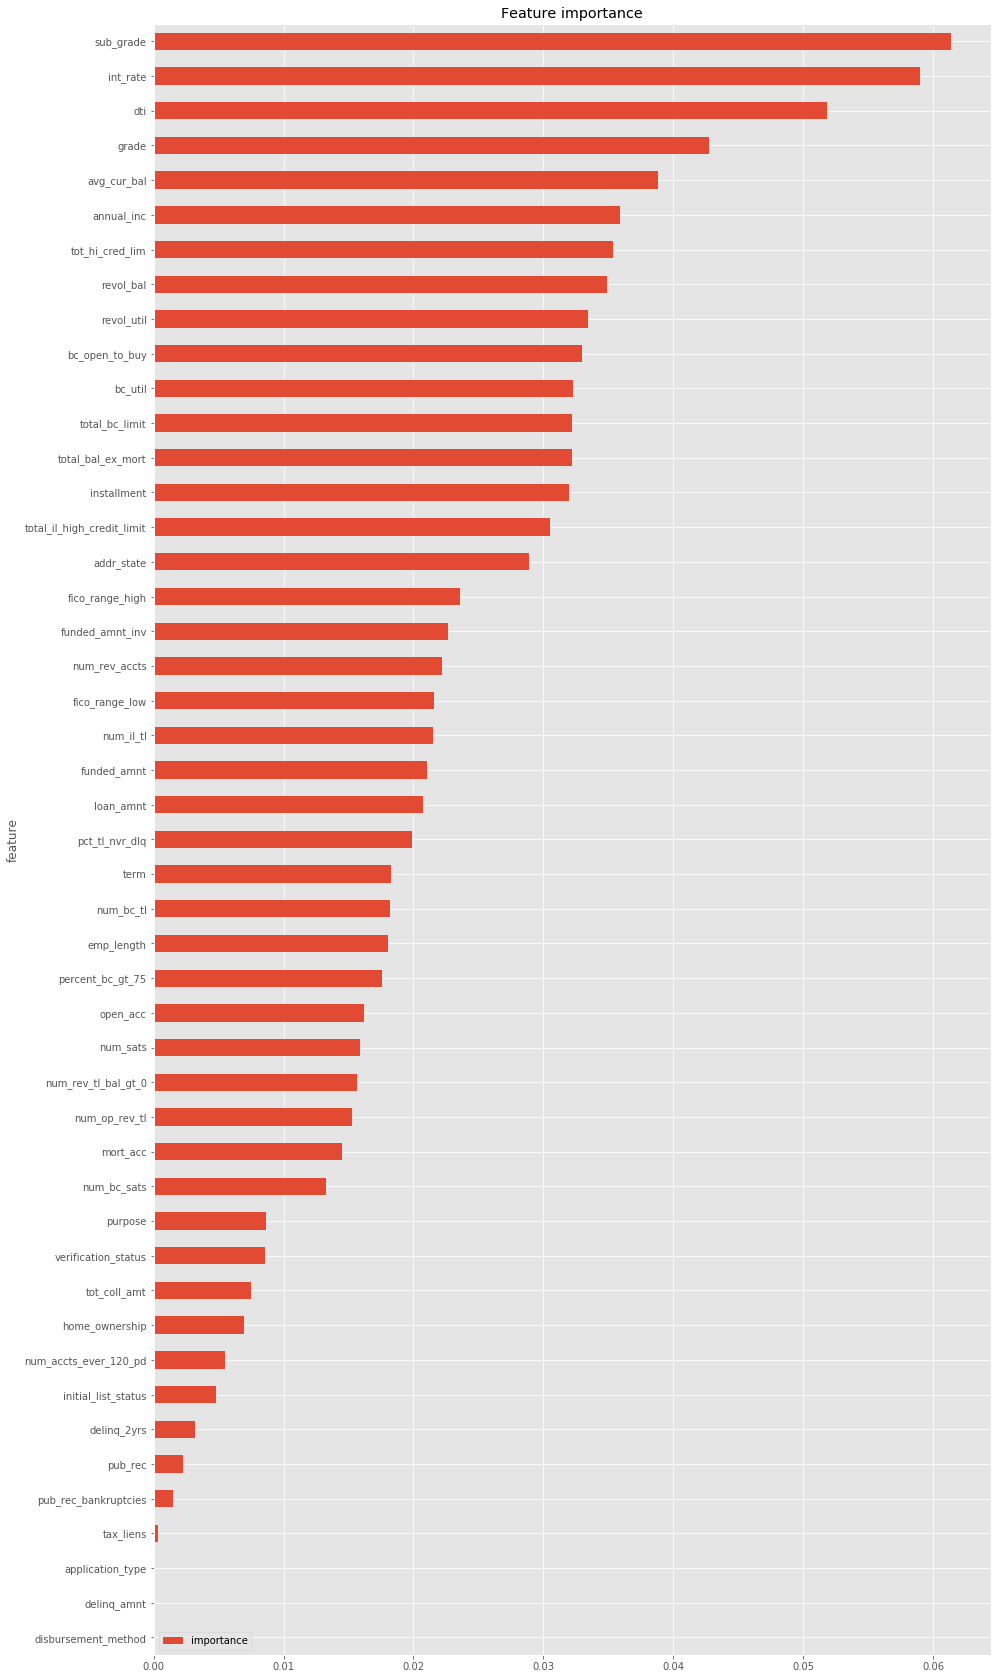

In [21]:
features = pd.DataFrame({'feature':X_train.columns,
                         'importance':random_search.best_estimator_.feature_importances_})

features = features.set_index('feature').sort_values('importance', ascending=True)

features.plot(kind='barh',figsize=(15,30)).set_title('Feature importance')